In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# read in training data set for housing prices
train = pd.read_csv('train.csv')

In [2]:
# Show na values for 50 columns with least NaN values
train_na = pd.DataFrame([train.isna()[column].value_counts() 
                         for column in train.columns]).reset_index()
train_na.rename(columns={'index':'Column',
                         0:'Present',
                         1:'Missing'}).sort_values(by='Present',
                                                   ascending=False).head(50)

,Column,Present,Missing
0,Id,1460.0,NaN
46,GrLivArea,1460.0,NaN
52,KitchenAbvGr,1460.0,NaN
51,BedroomAbvGr,1460.0,NaN
50,HalfBath,1460.0,NaN
49,FullBath,1460.0,NaN
48,BsmtHalfBath,1460.0,NaN
47,BsmtFullBath,1460.0,NaN
45,LowQualFinSF,1460.0,NaN
54,TotRmsAbvGrd,1460.0,NaN


In [3]:
# Show 20 columns with the most missing values
top_20_na = train_na.rename(columns={'index':'Column',
                             0:'Present',
                             1:'Missing'}).sort_values(by='Missing',
                                                       ascending=False).head(20)
top_20_na

,Column,Present,Missing
72,PoolQC,7.0,1453.0
74,MiscFeature,54.0,1406.0
6,Alley,91.0,1369.0
73,Fence,281.0,1179.0
57,FireplaceQu,770.0,690.0
3,LotFrontage,1201.0,259.0
58,GarageType,1379.0,81.0
59,GarageYrBlt,1379.0,81.0
60,GarageFinish,1379.0,81.0
63,GarageQual,1379.0,81.0


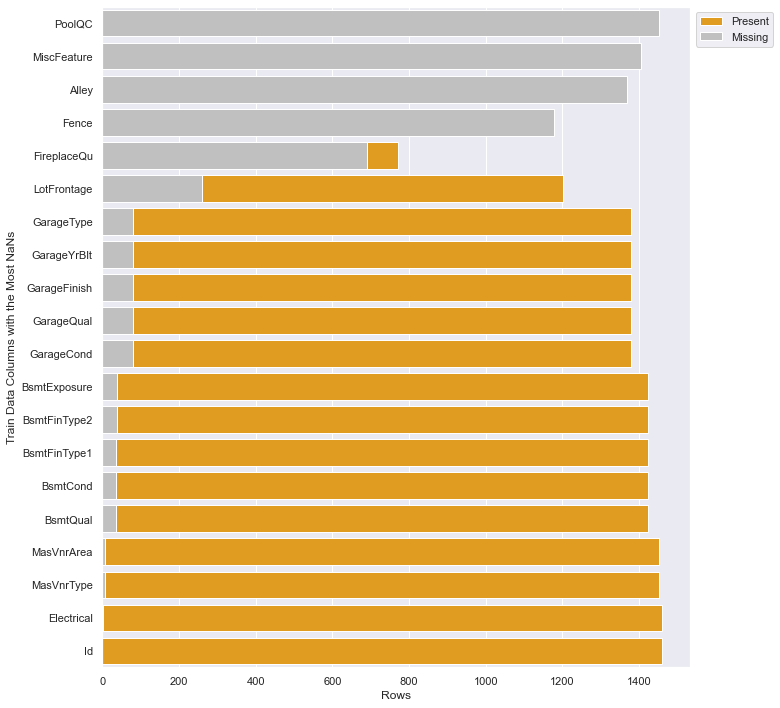

In [38]:
sns.set_theme(color_codes=True)

# Create barplot of 20 columns with the most missing data
plt.figure(figsize=(11,10), frameon=False)
sns.set_color_codes("pastel")
ax = sns.barplot(x="Present", y="Column", data=top_20_na,
            label="Present", color="orange")

sns.set_color_codes("muted")
ax = sns.barplot(x="Missing", y="Column", data=top_20_na,
           label='Missing', color='silver')

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
plt.xlabel('Rows')
plt.ylabel('Train Data Columns with the Most NaNs')
ax.figure.savefig('missing_data.png')
plt.tight_layout()


Text(0, 0.5, 'Variable Correlation \nto Sale Price')

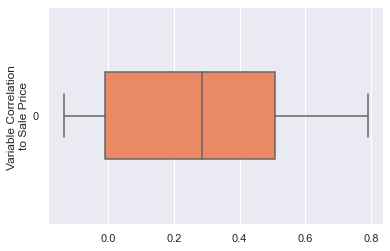

In [5]:
# find correlations between variables and save only 'SalePrice' col
SalePrice_corr_train = train.corr()['SalePrice'] 

# Create barplot of all columns with numerical values correlation to saleprice
sns.set_theme(color_codes=True)
sns.boxplot(data=SalePrice_corr_train[:37], orient='h', width=0.4,
           color='coral')
plt.ylabel('Variable Correlation \nto Sale Price')

In [6]:
SalePrice_corr_train[:37].describe()

count    37.000000
mean      0.273946
std       0.270706
min      -0.135907
25%      -0.011378
50%       0.284108
75%       0.507101
max       0.790982
Name: SalePrice, dtype: float64

In [7]:
# Create list of top 25% and bottom 25% of
# columns with numerical value correlations to Sale Price
SalePrice_corr_train_quarters = SalePrice_corr_train[((SalePrice_corr_train >= 0.507101) 
                      & (SalePrice_corr_train !=1)) 
                     | (SalePrice_corr_train <= -0.011378)]
SalePrice_corr_train_quarters.sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
Name: SalePrice, dtype: float64

OverallQual


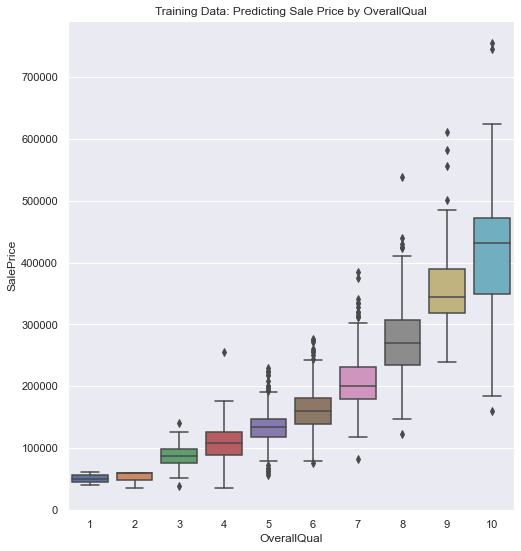

KitchenAbvGr


<Figure size 432x288 with 0 Axes>

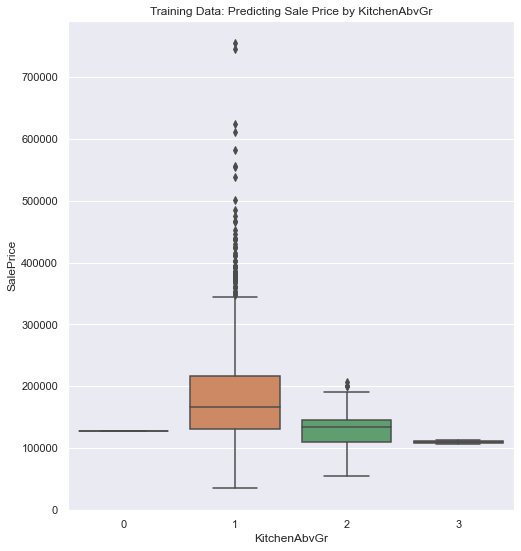

TotRmsAbvGrd


<Figure size 432x288 with 0 Axes>

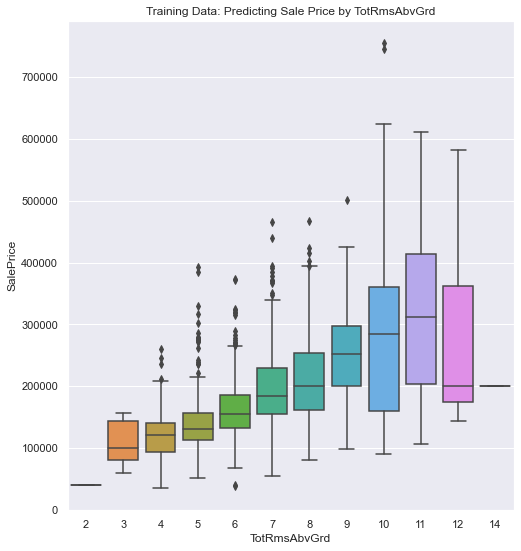

<Figure size 432x288 with 0 Axes>

In [41]:
sns.set_theme(color_codes=True)
of_interest = ['ExterQual', 'GarageFinish', 'OverallQual',
               'TotRmsAbvGrd', 'KitchenAbvGr']

for column in list(SalePrice_corr_train_quarters.index):
    for variable in of_interest:
        if column == variable:
            if len(train[column].value_counts()) < 50:
                print(f"{column}")
                plt.figure(figsize=(8,9), frameon=False)
                box = sns.boxplot(data=train, x=column, y='SalePrice')
                plt.title(f"Training Data: Predicting Sale Price by {column}")
                plt.show()
                box.figure.savefig(f"boxplot_{column}.png")
                plt.tight_layout()
            else:
                print(f"{column}")
                plt.figure(figsize=(8,9), frameon=False)
                lmplot = sns.lmplot(data=train, x=column, y='SalePrice')
                plt.title(f"Training Data: Predicting Sale Price by {column}")
                plt.show()
                lmplot.figure.savefig(f"lmplot_{column}.png")
                plt.tight_layout()


OverallQual


<Figure size 1152x1152 with 0 Axes>

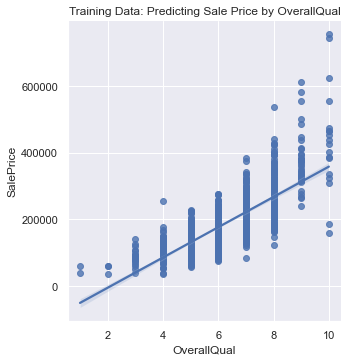

KitchenAbvGr


<Figure size 432x288 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

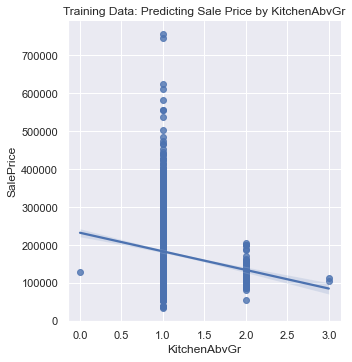

TotRmsAbvGrd


<Figure size 432x288 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

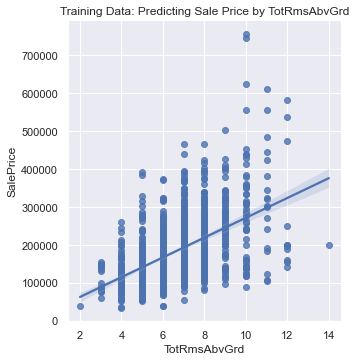

<Figure size 432x288 with 0 Axes>

In [48]:
sns.set_theme(color_codes=True)

for column in list(SalePrice_corr_train_quarters.index):
    for variable in of_interest:
        if column == variable:
            print(f"{column}")
            plt.figure(figsize=(16,16), frameon=False)
            g = sns.lmplot(data=train, x=column, y='SalePrice')
            plt.title(f"Training Data: Predicting Sale Price by {column}")
            plt.show()
            g.figure.savefig(f"lmplot_{column}.png")
            plt.tight_layout()

In [19]:
for column in train.columns:
    for variable in of_interest+['SalePrice']:
        if column == variable:
            print(f"{column}")
            display(train[column].describe())

OverallQual


count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

ExterQual


count     1460
unique       4
top         TA
freq       906
Name: ExterQual, dtype: object

KitchenAbvGr


count    1460.000000
mean        1.046575
std         0.220338
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64

TotRmsAbvGrd


count    1460.000000
mean        6.517808
std         1.625393
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64

GarageFinish


count     1379
unique       3
top        Unf
freq       605
Name: GarageFinish, dtype: object

SalePrice


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

OverallQual


<Figure size 1008x1008 with 0 Axes>

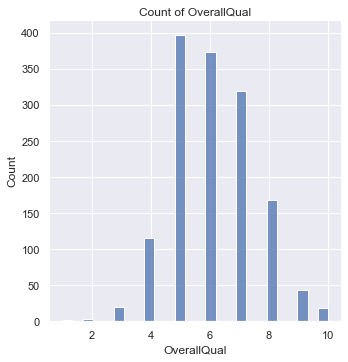

ExterQual


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

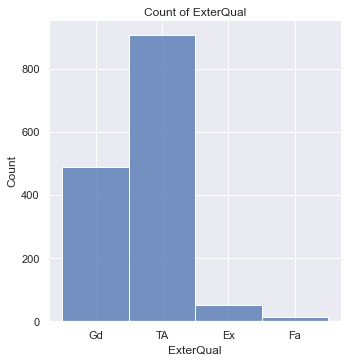

KitchenAbvGr


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

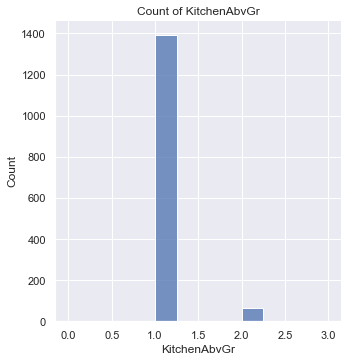

TotRmsAbvGrd


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

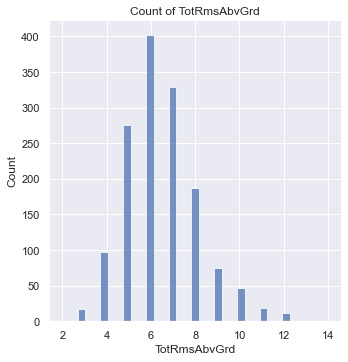

GarageFinish


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

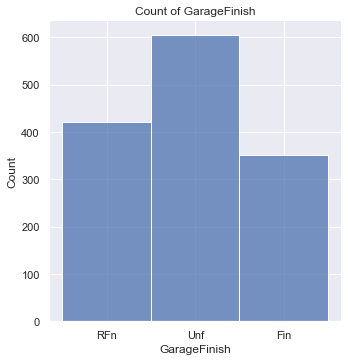

SalePrice


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

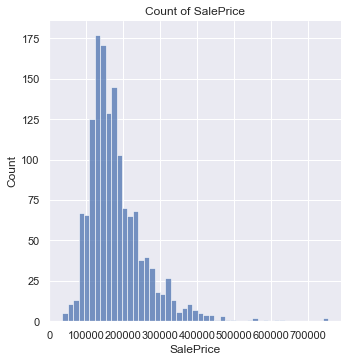

<Figure size 432x288 with 0 Axes>

In [50]:
sns.set_theme(color_codes=True)

for column in train.columns:
    for variable in of_interest+['SalePrice']:
        if column == variable:
            print(f"{column}")
            plt.figure(figsize=(14,14), frameon=False)
            s = sns.displot(train[column])
            plt.title(f"Count of {column}")
            plt.show()
            s.figure.savefig(f"histogram_{column}.png")
            plt.tight_layout()

In [12]:
non_numerical_col = list(set(train.columns) - set(train.corr().columns))

GarageFinish


<Figure size 1080x1080 with 0 Axes>

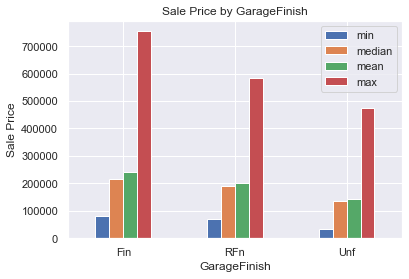

ExterQual


<Figure size 1080x1080 with 0 Axes>

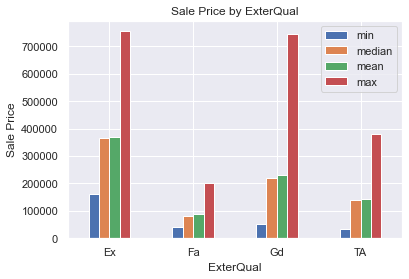

In [53]:
for column in non_numerical_col:
    for variable in of_interest:
        if column == variable:
            print(f"{column}")
            plt.figure(figsize=(15,15), frameon=False)
            column_grouped = train['SalePrice'].groupby(train[column]).agg(['min', 'median', 'mean', 'max']).reset_index()
            grp_bar = column_grouped.plot.bar(x=column, rot=0.3)
            plt.ylabel('Sale Price')
            plt.title(f"Sale Price by {column}")
            plt.show()
            grp_bar.figure.savefig(f"histogram_grouped_{column}_sale_price.png")

In [14]:
character_train = pd.get_dummies(train.loc[:,non_numerical_col + ['SalePrice']])
scaler = StandardScaler()

character_train.corr()['SalePrice'].reset_index()[1:].sort_values(by='SalePrice',ascending=False).head(20)

,index,SalePrice
122,BsmtQual_Ex,0.553105
244,KitchenQual_Ex,0.504094
49,Foundation_PConc,0.497734
165,ExterQual_Gd,0.452466
163,ExterQual_Ex,0.451164
25,BsmtFinType1_GLQ,0.434597
248,HeatingQC_Ex,0.434543
9,GarageFinish_Fin,0.419678
183,Neighborhood_NridgHt,0.402149
35,SaleType_New,0.357509


In [15]:
character_train.corr()['SalePrice'].reset_index()[1:].sort_values(by='SalePrice',ascending=True).head(20)

,index,SalePrice
166,ExterQual_TA,-0.589044
247,KitchenQual_TA,-0.519298
125,BsmtQual_TA,-0.452394
11,GarageFinish_Unf,-0.410608
103,MasVnrType_None,-0.374468
86,GarageType_Detchd,-0.354141
48,Foundation_CBlock,-0.343263
252,HeatingQC_TA,-0.312677
210,MSZoning_RM,-0.288065
108,LotShape_Reg,-0.267672


In [16]:
train_grouped = train.groupby(of_interest).agg(['min', 'max', 'mean','median'])
train_saleprice_grp = train_grouped['SalePrice']
train_saleprice_grp

min     max  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr                   
Ex        Fin          6           6            1             185000  185000   
                       7           7            1             222000  222000   
                                   8            1             311872  311872   
                       8           5            1             392500  392500   
                                   7            1             318000  394617   
...                                                              ...     ...   
TA        Unf          7           10           1             244400  295000   
                                   11           1             320000  320000   
                       8           7            1             161000  230000   
                                   10           1             359100  359100   
                                   11           1             381000  381000   

                                                                       mean  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr                  
Ex        Fin          6           6            1             185000.000000   
                       7           7            1             222000.000000   
                                   8            1             311872.000000   
                       8           5            1             392500.000000   
                                   7            1             356308.500000   
...                                                                     ...   
TA        Unf          7           10           1             267226.666667   
                                   11           1             320000.000000   
                       8           7            1             195500.000000   
                                   10           1             359100.000000   
                                   11           1             381000.000000   

                                                                median  
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr            
Ex        Fin          6           6            1             185000.0  
                       7           7            1             222000.0  
                                   8            1             311872.0  
                       8           5            1             392500.0  
                                   7            1             356308.5  
...                                                                ...  
TA        Unf          7           10           1             262280.0  
                                   11           1             320000.0  
                       8           7            1             195500.0  
                                   10           1             359100.0  
                                   11           1             381000.0  

[218 rows x 4 columns]

In [17]:
scaler = StandardScaler()
variables = ['min', 'max', 'mean', 'median']

train_standard = train_saleprice_grp
train_standard.loc[:, variables] = scaler.fit_transform(train_saleprice_grp[variables])
display(train_standard)

min  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1            -0.003977   
                       7           7            1             0.368132   
                                   8            1             1.271975   
                       8           5            1             2.082851   
                                   7            1             1.333604   
...                                                                ...   
TA        Unf          7           10           1             0.593409   
                                   11           1             1.353718   
                       8           7            1            -0.245345   
                                   10           1             1.746947   
                                   11           1             1.967195   

                                                                   max  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1            -0.475248   
                       7           7            1            -0.157941   
                                   8            1             0.612788   
                       8           5            1             1.304242   
                                   7            1             1.322397   
...                                                                ...   
TA        Unf          7           10           1             0.468096   
                                   11           1             0.682493   
                       8           7            1            -0.089335   
                                   10           1             1.017809   
                                   11           1             1.205620   

                                                                  mean  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1            -0.248115   
                       7           7            1             0.112687   
                                   8            1             0.989063   
                       8           5            1             1.775298   
                                   7            1             1.422381   
...                                                                ...   
TA        Unf          7           10           1             0.553709   
                                   11           1             1.068323   
                       8           7            1            -0.145725   
                                   10           1             1.449602   
                                   11           1             1.663157   

                                                                median  
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr            
Ex        Fin          6           6            1            -0.235795  
                       7           7            1             0.126388  
                                   8            1             1.006120  
                       8           5            1             1.795365  
                                   7            1             1.441097  
...                                                                ...  
TA        Unf          7           10           1             0.520678  
                                   11           1             1.085683  
                       8           7            1            -0.133013  
                                   10           1             1.468422  
                                   11           1             1.682795  

[218 rows x 4 columns]

In [18]:
mm_scaler = MinMaxScaler()

train_minmax = train_saleprice_grp
mm_scaler.fit(train_saleprice_grp[variables])

train_minmax[variables] = mm_scaler.fit_transform(train_saleprice_grp[variables])
display(train_minmax)

min  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1             0.253844   
                       7           7            1             0.316589   
                                   8            1             0.468995   
                       8           5            1             0.605724   
                                   7            1             0.479387   
...                                                                ...   
TA        Unf          7           10           1             0.354575   
                                   11           1             0.482778   
                       8           7            1             0.213145   
                                   10           1             0.549084   
                                   11           1             0.586223   

                                                                   max  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1             0.207991   
                       7           7            1             0.259402   
                                   8            1             0.384278   
                       8           5            1             0.496310   
                                   7            1             0.499252   
...                                                                ...   
TA        Unf          7           10           1             0.360835   
                                   11           1             0.395572   
                       8           7            1             0.270518   
                                   10           1             0.449901   
                                   11           1             0.480331   

                                                                  mean  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1             0.230401   
                       7           7            1             0.287351   
                                   8            1             0.425682   
                       8           5            1             0.549785   
                                   7            1             0.494079   
...                                                                ...   
TA        Unf          7           10           1             0.356964   
                                   11           1             0.438193   
                       8           7            1             0.246563   
                                   10           1             0.498375   
                                   11           1             0.532084   

                                                                median  
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr            
Ex        Fin          6           6            1             0.230401  
                       7           7            1             0.287351  
                                   8            1             0.425682  
                       8           5            1             0.549785  
                                   7            1             0.494079  
...                                                                ...  
TA        Unf          7           10           1             0.349350  
                                   11           1             0.438193  
                       8           7            1             0.246563  
                                   10           1             0.498375  
                                   11           1             0.532084  

[218 rows x 4 columns]